# Language Translation with Word Level seq2seq DL Models

The objective is to convert a German sentence (sequence of words) to English using a Neural Machine Translation (NMT) system based on word level encoder-decoder models.

![](https://i.imgur.com/So32H7U.png)

We will use German-English sentence pairs data from http://www.manythings.org/anki/


Sequence-to-Sequence (seq2seq) models are used for a variety of NLP tasks, such as text summarization, speech recognition, language translation, text-to-speech, speech-to-text among others. Our aim is to translate german to english sentences.

Here, both, the input and output are sentences. In other words, these sentences are a sequence of words going in and out of our model.

![](https://i.imgur.com/Uk1tCPo.png)

A typical seq2seq model is also known as an encoder-decoder model and has 2 major components:
- The encoder
- The decoder

Both these parts are essentially two different sequential models like RNNs\LSTMs which are combined together.

![](https://i.imgur.com/bT6PAtv.png)

In [ ]:
!nvidia-smi

Tue Oct  5 16:56:47 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Download the Dataset

In [ ]:
!wget http://www.manythings.org/anki/deu-eng.zip
!unzip deu-eng.zip
!ls -l

--2021-10-05 16:56:48--  http://www.manythings.org/anki/deu-eng.zip
Resolving www.manythings.org (www.manythings.org)... 104.21.92.44, 172.67.186.54, 2606:4700:3033::ac43:ba36, ...
Connecting to www.manythings.org (www.manythings.org)|104.21.92.44|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9079830 (8.7M) [application/zip]
Saving to: ‘deu-eng.zip’

deu-eng.zip         100%[===================>]   8.66M  14.8MB/s    in 0.6s    

2021-10-05 16:56:49 (14.8 MB/s) - ‘deu-eng.zip’ saved [9079830/9079830]

Archive:  deu-eng.zip
  inflating: deu.txt                 
  inflating: _about.txt              
total 45680
-rw-r--r-- 1 root root     1441 Jul 14 10:16 _about.txt
-rw-r--r-- 1 root root  9079830 Jul 14 01:16 deu-eng.zip
-rw-r--r-- 1 root root 37686235 Jul 14 10:16 deu.txt
drwxr-xr-x 1 root root     4096 Sep 30 17:12 sample_data


In [ ]:
!pip install tqdm

# Load up the dataset

In [ ]:
import numpy as np

FILE_NAME = './deu.txt'
with open(FILE_NAME, mode='rt', encoding='utf-8') as infile:
  data = infile.read()
  sentences = data.strip().split('\n')
  sentences = [item.split('\t') for item in sentences]
  eng_deu = np.array(sentences)

eng_deu = eng_deu[:50000]
eng_deu

array([['Go.', 'Geh.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['Hi.', 'Hallo!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['Hi.', 'Grüß Gott!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ['We took a wrong turn.', 'Wir sind falsch abgebogen.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #823901 (jellorage) & #2112094 (freddy1)'],
       ['We traveled together.', 'Wir waren zusammen auf Reisen.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1582121 (Spamster) & #1600396 (Pfirsichbaeumchen)'],
       ['We traveled together.', 'Wir sind zusammen gereist.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1582121 (Spamster) & #1600398 (Pfirsichbaeumchen)']],
      dtype='<U537')

In [ ]:
deu = eng_deu[:,1]
eng = eng_deu[:,0]
eng, deu

(array(['Go.', 'Hi.', 'Hi.', ..., 'We took a wrong turn.',
        'We traveled together.', 'We traveled together.'], dtype='<U537'),
 array(['Geh.', 'Hallo!', 'Grüß Gott!', ..., 'Wir sind falsch abgebogen.',
        'Wir waren zusammen auf Reisen.', 'Wir sind zusammen gereist.'],
       dtype='<U537'))

# Basic Text Pre-processing

In [ ]:
import string

# Remove punctuation and lowercase
eng = np.array([s.translate(str.maketrans('', '', string.punctuation)).lower() for s in eng])
deu = np.array([s.translate(str.maketrans('', '', string.punctuation)).lower() for s in deu])
eng, deu

(array(['go', 'hi', 'hi', ..., 'we took a wrong turn',
        'we traveled together', 'we traveled together'], dtype='<U20'),
 array(['geh', 'hallo', 'grüß gott', ..., 'wir sind falsch abgebogen',
        'wir waren zusammen auf reisen', 'wir sind zusammen gereist'],
       dtype='<U118'))

# Viewing Sentence Lengths

In [ ]:
eng_len = [len(s.split()) for s in eng]
deu_len = [len(s.split()) for s in deu]

max(eng_len), max(deu_len)

(6, 15)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6165a4b890>,
      dtype=object)

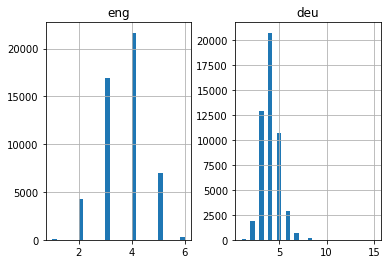

In [ ]:
import pandas as pd
%matplotlib inline

length_df = pd.DataFrame({'eng':eng_len, 'deu':deu_len})
length_df.hist(bins=30)

# Converting Text to Sequences of Numbers

In [ ]:
from tensorflow import keras

eng_tokenizer = keras.preprocessing.text.Tokenizer()
eng_tokenizer.fit_on_texts(eng)
eng_vocab_size = len(eng_tokenizer.word_index) + 1
eng_length = max(eng_len)
print('Max eng text length:', eng_length)
print('English Vocabulary Size:', eng_vocab_size)

Max eng text length: 6
English Vocabulary Size: 6152


In [ ]:
deu_tokenizer = keras.preprocessing.text.Tokenizer()
deu_tokenizer.fit_on_texts(deu)
deu_vocab_size = len(deu_tokenizer.word_index) + 1
deu_length = max(deu_len)
print('Max deu text length:', deu_length)
print('German Vocabulary Size:', deu_vocab_size)

Max deu text length: 15
German Vocabulary Size: 10112


In [ ]:
from sklearn.model_selection import train_test_split

train_deu, test_deu, train_eng, test_eng = train_test_split(deu, eng, test_size=0.2, random_state = 42)
train_deu.shape, test_deu.shape, train_eng.shape, test_eng.shape

((40000,), (10000,), (40000,), (10000,))

In [ ]:
train_deu, train_eng

(array(['passt auf euch auf', 'wir sehen uns später',
        'ich weiß es mit sicherheit', ..., 'ich gebe dir ein bier aus',
        'ich bin ein mann', 'wer ist hinter euch her'], dtype='<U118'),
 array(['look after yourself', 'ill see you later', 'i know it for a fact',
        ..., 'ill buy you a beer', 'im a man', 'whos after you'],
       dtype='<U20'))

### We pad the sequences of texts also to make sure they are of uniform length

In [ ]:
train_deu_enc = deu_tokenizer.texts_to_sequences(train_deu)
train_deu_enc = keras.preprocessing.sequence.pad_sequences(train_deu_enc, maxlen=deu_length, padding='post')

train_eng_enc = eng_tokenizer.texts_to_sequences(train_eng)
train_eng_enc = keras.preprocessing.sequence.pad_sequences(train_eng_enc, maxlen=eng_length, padding='post')

train_deu_enc.shape, train_eng_enc.shape

((40000, 15), (40000, 6))

In [ ]:
test_deu_enc = deu_tokenizer.texts_to_sequences(test_deu)
test_deu_enc = keras.preprocessing.sequence.pad_sequences(test_deu_enc, maxlen=deu_length, padding='post')

test_eng_enc = eng_tokenizer.texts_to_sequences(test_eng)
test_eng_enc = keras.preprocessing.sequence.pad_sequences(test_eng_enc, maxlen=eng_length, padding='post')

test_deu_enc.shape, test_eng_enc.shape

((10000, 15), (10000, 6))

# Build seq2seq Model Architecture

![](https://i.imgur.com/3ZVi97s.png)

- For the encoder, we will use an embedding layer and an LSTM layer
- For the decoder, we will use another LSTM layer followed by a dense layer
- Repeat Vector helps pass the output sequence from encoder to all LSTM cells in the decoder

We leverage the full power of GPUs by using the CUDA variant of the LSTM models.

In [ ]:
EMBEDDING_DIM = 512
LSTM_UNITS = 512

encoder_inputs = keras.layers.Input(shape=(deu_length,))
enc_emb =  keras.layers.Embedding(deu_vocab_size, EMBEDDING_DIM)(encoder_inputs)
encoder_lstm = keras.layers.LSTM(LSTM_UNITS, return_sequences=False)(enc_emb)
rp_vec = keras.layers.RepeatVector(eng_length)(encoder_lstm)

decoder_lstm = keras.layers.LSTM(LSTM_UNITS, return_sequences=True)(rp_vec)
decoder_softmax = keras.layers.Dense(eng_vocab_size, activation='softmax')(decoder_lstm)
model = keras.models.Model(inputs=encoder_inputs, outputs=decoder_softmax)

model.compile(optimizer=keras.optimizers.RMSprop(lr=0.001), loss='sparse_categorical_crossentropy')
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 15)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 512)           5177344   
_________________________________________________________________
lstm (LSTM)                  (None, 512)               2099200   
_________________________________________________________________
repeat_vector (RepeatVector) (None, 6, 512)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 6, 512)            2099200   
_________________________________________________________________
dense (Dense)                (None, 6, 6152)           3155976   
Total params: 12,531,720
Trainable params: 12,531,720
Non-trainable params: 0
_________________________________________________

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


# Model Training

We save the model with minimum loss here also with checkpointing

[the, ball, was, rolling] => [2, 34, 5, 100, 0, 0] => [[2, 34, 5, 100, 0, 0]]

In [ ]:
history = model.fit(train_deu_enc, train_eng_enc.reshape(train_eng_enc.shape[0], train_eng_enc.shape[1], 1),
          epochs=50, batch_size=512,
          validation_split = 0.1, verbose=1)

Epoch 1/50
71/71 [==============================] - 9s 46ms/step - loss: 4.0587 - val_loss: 3.6815
Epoch 2/50
71/71 [==============================] - 3s 38ms/step - loss: 3.6502 - val_loss: 3.5484
Epoch 3/50
71/71 [==============================] - 3s 38ms/step - loss: 3.4654 - val_loss: 3.4060
Epoch 4/50
71/71 [==============================] - 3s 38ms/step - loss: 3.3035 - val_loss: 3.2712
Epoch 5/50
71/71 [==============================] - 3s 38ms/step - loss: 3.1934 - val_loss: 3.2489
Epoch 6/50
71/71 [==============================] - 3s 38ms/step - loss: 3.1187 - val_loss: 3.2047
Epoch 7/50
71/71 [==============================] - 3s 38ms/step - loss: 3.0080 - val_loss: 3.0613
Epoch 8/50
71/71 [==============================] - 3s 38ms/step - loss: 2.8575 - val_loss: 2.9323
Epoch 9/50
71/71 [==============================] - 3s 38ms/step - loss: 2.7094 - val_loss: 2.8108
Epoch 10/50
71/71 [==============================] - 3s 38ms/step - loss: 2.5803 - val_loss: 2.7077
Epoch 11/

### We also save the final model to check it's performance

In [ ]:
model.save('my_nmt_model.h5')

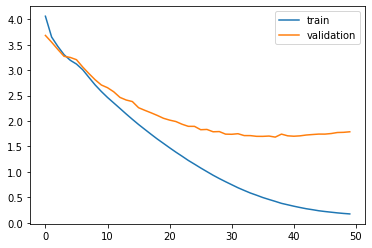

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])

# Text Generator

We build a utility function to generate text sequences based on the output prediction sequences

whenever we do

`model.predict(train_deu_enc.reshape((train_deu_enc.shape[0], train_deu_enc.shape[1])), verbose=1)` on a german sentence (sequence of tokens)

it will generate a sequence of softmax probabilities for the english words i.e

e,g german sentence token input => sen = [12, 2, 122, 33, 0, 0....,0]

model.predict([sen]) => list of softmax probabilities
```
[
  [0.1, 0.005,......0.25], # class probabilities for all possible english words for 1st token
  [0.21, 0.05,......0.05], # class probabilities for all possible english words for 2nd token
  ..,
  ..,
  ..,
  [0.5, 0.1,......0.005], # class probabilities for all possible english words for 6th token
]
```
then we use np.argmax to get the word IDs with max probability from above list

[2, 11, 200, 101, 0, 0]

and then use the english vocabulary to translate IDs to words

[the, ball, was, rolling, , ]

In [ ]:
from tqdm import tqdm
pd.set_option('display.max_colwidth', 500)

eng_idx2word = {v:k for k, v in eng_tokenizer.word_index.items()}

def generate_prediction_texts(pred_seqs, idx2word_map):
  pred_texts = []

  for pred in tqdm(preds):
    temp = []
    for idx in range(len(pred)):
      w = eng_idx2word.get(pred[idx], None)
      if idx > 0:
        if (w == eng_idx2word.get(pred[idx-1], None)) or (w == None):
            temp.append('')
        else:
            temp.append(w)

      else:
        if(w == None):
            temp.append('')
        else:
            temp.append(w)

    pred_texts.append(' '.join(temp))
  return pred_texts


# Perform Language Translation with Trained Models

In [ ]:
final_model = keras.models.load_model('./my_nmt_model.h5')

# Translation on Train Data

### Performance of Final Model on Train Data

In [ ]:
model = final_model
pred_probs = model.predict(train_deu_enc.reshape((train_deu_enc.shape[0], train_deu_enc.shape[1])), verbose=1)
preds = [np.argmax(i, axis=1) for i in pred_probs]
# convert predictions into text (English)
pred_texts = generate_prediction_texts(pred_seqs=preds, idx2word_map=eng_idx2word)
pred_df = pd.DataFrame({'source': train_deu, 'target' : train_eng, 'predicted' : pred_texts})

1250/1250 [==============================] - 3s 2ms/step


100%|██████████| 40000/40000 [00:00<00:00, 169671.81it/s]


In [ ]:
pred_df.head(50).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
source,passt auf euch auf,wir sehen uns später,ich weiß es mit sicherheit,hat tom euch geküsst,lassen sie mich tom anrufen,fehler sind unvermeidlich,dieses buch habe ich geschrieben,ich liebe boston sehr,ich weiß dass tom zu hause ist,ich bin schon dran,er muss tot sein,sind sie lehrer,sie werden schon klarkommen,lass uns hier lang gehen,wird es sehr weh tun,tom ist beunruhigt,sie lebten in boston,gib mir noch eins,ich weiß was ich fühle,tom hat mich sitzenlassen,kannst du reden,hören sie nicht auf sie,tom wird euch nichts in den weg legen,tom denkt logisch,können sie das beweisen,ich bin noch nicht fertig,hören sie auf zu fluchen,ich bin ein alter mann,tom möchte essen,ich habe davon gehört,tom schwimmt,tom will arbeiten,er hat ein scharfes gehör,hallo,du hast eine stunde zeit,ich nehme dieses,wir werden schon klarkommen,ich bin nicht sicher,tom ist schneller,wir sind zu fuß gegangen,das ist die volle wahrheit,tom trat als kandidat bei der wahl zum bürgermeister an,er kam spät an,rutsche ich,ich habe es nicht gehört,mein goldfisch ist gestorben,brauche ich eine rechtsanwältin,du hast ein gutes gedächtnis,du siehst toll aus,du brauchst einen spielhebel
target,look after yourself,ill see you later,i know it for a fact,did tom kiss you,let me call tom,mistakes happen,i wrote this book,i really love boston,i know tom is home,im already on it,he must be dead,are you a teacher,theyll be fine,lets go this way,will it hurt a lot,toms concerned,they lived in boston,give me another one,i know what i feel,tom dumped me,can you talk,dont listen to her,tom wont stop you,tom is logical,can you prove it,im not done,stop swearing,im an old man,tom wants to eat,i heard about it,tom is swimming,tom wants to work,he has sharp hearing,hi,youve got an hour,ill take this one,well be fine,im not sure,tom is quicker,we walked,its absolutely true,tom ran for mayor,he arrived late,am i slipping,i didnt hear it,my goldfish died,do i need a lawyer,your memory is good,you look great,you need a joystick
predicted,look after,ill see you later,i know it for a fact,did tom kiss you,let me call tom,mistakes happen,i wrote this book,i really love boston,i know tom is home,im already on it,he must be dead,are you a teacher,theyll be fine,lets go this way,will it hurt a lot,toms is,they lived in boston,give me another one,i know what i feel,tom dumped me,can you talk,dont listen to her,tom wont stop you,tom is logical,can you prove it,im not done to,stop swearing,im an old man,tom wants to eat,i heard about it,toms is,tom wants to work,he has sharp hearing,hello,youve got one hour,ill take this one,well be fine,im not sure,tom is quicker,we went on,its absolutely true,tom ran for mayor,he arrived late,am i slipping,i didnt hear it,my goldfish died,do i need a lawyer,your memory is good,you look great,you need a joystick


In [ ]:
pred_df.iloc[500:550].T

,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549
source,sie sehen gut aus,sie ist eine schlechte köchin,tom hat heimweh,tom sang weiter,da müsst ihr wohl in den sauren apfel beißen,ich werde dafür sorgen,verkrümele dich,ich bin im auto,lassen sie mich ihnen helfen,tom wirkt sehr glücklich,ich wusch mir die hände,tom ist mein feind,tom versuchte es,gib tom das geld,sie mögen äpfel,ich wollte nicht sterben,ich möchte einen vermögenden eindruck machen,tom ist betrügerisch,ich werde ihre hilfe brauchen,das mädchen springt,lasst es uns noch einmal versuchen,lass mich einfach schlafen,lass tom das machen,ich habe mich wirklich sehr angestrengt,ich habe tom das tun lassen,mach dich locker,tom ist jenseits der dreißig,ich gehöre nicht hierher,ist das toms hund,sie kommen zu spät,mach es auf deine weise,tom hat sich ein neues auto gekauft,vielleicht war das tom,dieses auto läuft super,sie hasst es zu rennen,tom hatte einen plan,tom hob seine arme hoch,ich liebe dieses foto,es hatte einen süßen geschmack,das ist immer noch neu für mich,hat tom sich mit dir in verbindung gesetzt,ich weiß was du willst,tom ertrank,du hast mir nicht geholfen,tom ist noch immer dort,ich möchte jetzt anfangen,ich brauche ein taschentuch,tom lebt hier,warum hast du angehalten,ist tom bei klarem verstand
target,they look good,she is a poor cook,tom feels homesick,tom kept on singing,bite the bullet,ill see to that,go away,im in the car,let me help you,tom looks very happy,i washed my hands,tom is my enemy,tom tried,give tom the money,they like apples,i didnt want to die,i want to look rich,tom is deceitful,ill need your help,the girl is jumping,lets try once again,just let me sleep,let tom do that,i tried really hard,i made tom do that,loosen up,tom is past thirty,i dont belong here,is that dog toms,youre too late,do it your way,tom bought a new car,maybe it was tom,this car runs great,she hates running,tom had a plan,tom raised his arms,i love that photo,it tasted sweet,its still new to me,did tom contact you,i know what you want,tom was drowning,you didnt help me,tom is still there,i want to start now,i need a tissue,tom lives here,why did you stop,is tom lucid
predicted,you look good,she is a poor cook,tom is homesick,tom kept on singing,bite the bullet,ill do to of it,go away,im in the car,let me help,tom looks very happy,i washed my hands,tom is my enemy,tom tried,give tom the money,they like apples,i didnt want to die,i want to look rich,tom is deceitful,ill need your help,the girl is jumping,lets try it again,just let me sleep,let tom do that,i tried really hard,i made tom do that,loosen up,tom is past thirty,i dont belong here,is this dog toms,theyre too late,do it your way,tom bought a new car,maybe it was tom,this car runs great,she hates running,tom had a plan,tom raised his arms,i love this photo,it tasted sweet,its still new to me,did tom contact you,i know what you want,tom was,you didnt help me,tom is still there,i want to start now,i need a tissue,tom lives here,why did you stop,is tom lucid


# Translation on Test Data

### Performance of Final Model on Test Data

In [ ]:
model = final_model
pred_probs = model.predict(test_deu_enc.reshape((test_deu_enc.shape[0], test_deu_enc.shape[1])), verbose=1)
preds = [np.argmax(i, axis=1) for i in pred_probs]
# convert predictions into text (English)
pred_texts = generate_prediction_texts(pred_seqs=preds, idx2word_map=eng_idx2word)
pred_df = pd.DataFrame(
                        {'source': test_deu,
                        'target' : test_eng,
                        'predicted' : pred_texts}
                       )

313/313 [==============================] - 2s 3ms/step


100%|██████████| 10000/10000 [00:00<00:00, 163738.94it/s]


In [ ]:
pred_df.head(50).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
source,tom ist kein neuling,es war nicht schwer,er ist gegangen,das gefällt mir nicht,lesen sie das buch vor,du musst nach hause,tom war höflich,tom rannte los,ich bin kellner,ich bin in london angekommen,lass mich dir helfen,es ist eiskalt,ich war am arbeiten,ich bin ein junge,es ist zappenduster,gib mir diesen besen,tom wollte das haben,wir haben uns umgesehen,ich kenne sie alle,er ist ein medium,ich sehe eine maus,du hast meinen tag gerettet,ich habe dich gesehen,tom roch gas,es wird keine rolle spielen,tom ist sehr offenherzig,was habe ich falsch gemacht,ich hoffe es gefällt dir,ich will nicht weinen,tom starb an krebs,er hat weise gehandelt,ich bin nicht austauschbar,komm hier raus,ich esse käse,ich bin mir sicher dass ich helfen kann,wir können das gut,tom macht sich zu viele sorgen,wo sind die akten,diese tür will nicht aufgehen,wir rufen dich,tom war streitlustig,komm da raus,es war meine absicht,ich bin damit zufrieden,ich weiß dass du mich liebst,tom braucht bares,tom ist ein städter,tom ist gesellig,sie können mich nicht entlassen,ich habe brave kinder
target,tom isnt a rookie,it wasnt hard,he left,i dont like it,read the book aloud,you have to go home,tom was polite,tom took off running,im a waiter,i arrived in london,allow me to help you,it is freezing cold,i was working,i am a boy,it is pitch dark,hand me that broom,tom wanted that,we looked about us,i know them all,he is a psychic,i see a mouse,you made my day,i saw you,tom smelled gas,it wont matter,tom is very frank,what did i do wrong,i hope you like it,i dont want to cry,tom died of cancer,he has acted wisely,im irreplaceable,come out here,i eat cheese,im sure i can help,were good at it,tom worries too much,where are the files,that door wont open,well call you,tom was belligerent,come out of there,it was my plan,im happy with that,i know you love me,tom needs some cash,tom is a townie,tom is gregarious,you cant fire me,i have good kids
predicted,tom isnt a,it wasnt very,he left,i dont like that,read the book aloud,you need leave home,tom was courteous,tom ran to,im a waiter,i arrived up better,let me help,its freezing,i was to,i am a boy,its broken,give me the,tom wanted this,we have about to,i know all,hes a,i have a lot,you have my arm,i saw you,tom drives me,it wont matter,tom is very private,what did i do,i hope i like it,i dont want to cry,tom died of cancer,he has wrong,im not evil,get here with there,i eat eating,im glad i cant,we can well,tom is very well,where are the,this phone wont leave,well call you,tom was sneaky,get out of there,it was my,im sure with,i know you like me,tom needs a,tom is a art lover,tom is immature,you cant fire me,ive have no kids


In [ ]:
pred_df.iloc[500:550].T

,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549
source,ich verdanke dir so viel,sie dürfen gehen,tom ist schnell,tom saß neben maria,nehmen sie noch einen,probieren sie die hier an,folge deinem verlangen,ich war traurig,tom ist verärgert,halt die klappe und hör zu,tom überlebte,ich habe tom dort gesehen,vielleicht wird es bald regnen,ich werde dir nicht helfen,wir haben gerade erst angefangen,sie werden nicht erschossen,tom ist impulsiv,tom ist telepath,lass tom nachhause gehen,das fleisch ist zäh,ich kann gut sehen,die katzen sind in sicherheit,das ist nicht toms auto,tom ist ein überlebenskünstler,das war ein fehler,wir haben geklatscht,ich glaube an tom,ich nehme es an,ist das zu schwierig,ich bin der beste,das ist nicht von mir,ich bin erste,ich habe es umsonst bekommen,ich kenne tom bereits,ich habe sie schreien gehört,seid ihr glücklich,meine socken sind nass,könnt ihr französisch sprechen,hier können wir nicht reden,tom fühlte sich ausgeschlossen,tom ist geblieben,isst du gerne maisgrütze,ich bat um seine hilfe,seid alle ruhig,ich will zurückgehen,die kiste ist voll,tom hat euren wagen gestohlen,das sind alles touristen,ich trat in die marine ein,nur eine minute
target,i owe you so much,youre free to go,tom is fast,tom sat next to mary,have another,try these on,follow your desire,i was feeling blue,tom is resentful,shut up and listen,tom survived,i saw tom in there,it may rain soon,i will not help you,we just got started,they wont be shot,tom is impulsive,tom is a telepath,let tom go home,the meat is tough,i have good eyes,the cats are safe,this isnt toms car,tom is a survivalist,that was a mistake,we applauded,i believe in tom,i suppose so,is that too hard,im the best,its not from me,im first,i got it for free,i already know tom,i heard you scream,are you guys happy,my socks are wet,can you speak french,we cant talk here,tom felt excluded,tom stayed,do you like grits,i asked for his help,be quiet all of you,i want to go back,the box is full,tom stole your car,theyre all tourists,i joined the navy,just a minute
predicted,i really you much,you may go,toms fast,tom sat beside mary,take another,try the,take mine,i was sad,tom is angry,shut up and listen,tom is,i saw tom there,maybe might rain soon,i wont help you,weve just get,they wont be,tom is possessed,tom is cantankerous,let tom go alone,the meat is fresh,i have good,the are weak,this is isnt toms,tom is a,that was a mistake,we have each,i believe in tom,i look it up,is that too hard,im the best,this not sale,im am,i got it for today,i know tom,i heard you scream,are you happy,my socks are dirty,can you speak french,we cant go,tom felt unprepared,tom has animals,do you like to cook,i asked i on help,be quiet,i want to go out,the house is full,tom stole your car,these all ready,i jog the is,just a minute


In [ ]:
# To evaluate translation models using metrics
# BLEU Score